In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

In [378]:
df = acquire.get_titanic_data()
df.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [379]:
df = df.drop(columns=['Unnamed: 0', 'class', 'embarked'])
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,NaN,Southampton,1


In [380]:
df.isna().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
deck            688
embark_town       2
alone             0
dtype: int64

In [381]:
# Drop deck because there are far too many nulls
df = df.drop(columns=["deck"])

In [382]:
# Let's fill embark_town with the most common observation
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())

In [384]:
# Let's investigate the observations with missing age
# My first thought was empty age values might indicate children
# Looks like most of these individuals were traveling alone
no_age_info = df[df.age.isna()]
no_age_info.alone.value_counts()

1    133
0     44
Name: alone, dtype: int64

In [385]:
# Let's see how similar this group is to the population
for column in df.drop(columns=["age", "fare"]).columns:
    print(column)
    print("Population:")
    print(df[column].value_counts(normalize=True))
    print("No age")
    print(no_age_info[column].value_counts(normalize=True))
    print()
    print()

passenger_id
Population:
0      0.001122
598    0.001122
587    0.001122
588    0.001122
589    0.001122
         ...   
300    0.001122
301    0.001122
302    0.001122
303    0.001122
890    0.001122
Name: passenger_id, Length: 891, dtype: float64
No age
5      0.00565
454    0.00565
552    0.00565
557    0.00565
560    0.00565
        ...   
304    0.00565
306    0.00565
324    0.00565
330    0.00565
888    0.00565
Name: passenger_id, Length: 177, dtype: float64


survived
Population:
0    0.616162
1    0.383838
Name: survived, dtype: float64
No age
0    0.706215
1    0.293785
Name: survived, dtype: float64


pclass
Population:
3    0.551066
1    0.242424
2    0.206510
Name: pclass, dtype: float64
No age
3    0.768362
1    0.169492
2    0.062147
Name: pclass, dtype: float64


sex
Population:
male      0.647587
female    0.352413
Name: sex, dtype: float64
No age
male      0.700565
female    0.299435
Name: sex, dtype: float64


sibsp
Population:
0    0.682379
1    0.234568
2    0.03142

In [386]:
df.age = df.age.fillna(value=df.age.median())

In [387]:
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])


df = df.drop(columns=['sex', 'embark_town'])


df = pd.concat([df, dummy_df], axis=1)
df.head()

,passenger_id,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0,0
2,2,1,3,26.0,0,0,7.9250,1,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,1,0,1


In [388]:
from prepare import split

train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)


In [389]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

In [341]:
y_train[0:10]

583    0
165    1
50     0
259    1
306    1
308    0
314    0
883    0
459    0
180    0
Name: survived, dtype: int64

In [296]:
train.survived.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [390]:
baseline = y_train.mode()

In [391]:
matches_baseline_prediction = (y_train == 0)

In [392]:
baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [300]:
tree1 = DecisionTreeClassifier(max_depth=1, random_state=123)

In [301]:
tree1 = tree1.fit(X_train, y_train)

In [302]:
y_predictions = tree1.predict(X_train)

In [303]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree1.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [230]:
pd.DataFrame(confusion_matrix(y_train, y_predictions))

,0,1
0,265,42
1,58,133


In [195]:
pd.crosstab(y_train, y_predictions)

col_0,0,1
survived,,
0,265,42
1,58,133


In [196]:
print(classification_report(y_train, y_predictions))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



In [197]:
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.820433,0.760000,0.799197,0.790217,0.797255
recall,0.863192,0.696335,0.799197,0.779764,0.799197
f1-score,0.841270,0.726776,0.799197,0.784023,0.797358
support,307.000000,191.000000,0.799197,498.000000,498.000000


In [70]:
TP = 265
FP = 58
FN = 42
TN = 133
ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7991967871485943
True Positive Rate: 0.8631921824104235
False Positive Rate: 0.3036649214659686
True Negative Rate: 0.6963350785340314
False Negative Rate: 0.13680781758957655
Precision: 0.8204334365325078
Recall: 0.8631921824104235
F1 Score: 0.8412698412698413
Support (0): 307
Support (1): 191


In [198]:
for i in range(2, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.820433    0.760000  0.799197    0.790217      0.797255
recall       0.863192    0.696335  0.799197    0.779764      0.799197
f1-score     0.841270    0.726776  0.799197    0.784023      0.797358
support    307.000000  191.000000  0.799197  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.829341    0.817073  0.825301    0.823207      0.824636
recall       0.902280    0.701571  0.825301    0.801925      0.825301
f1-score     0.864275    0.754930  0.825301    0.809602      0.822337
support    307.000000  191.000000  0.825301  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.853211    0.836257   0.84739    0.844734      0.846709
recall       0.908795    0.748691   0.84739    0.828743      0.847390
f1-score     

In [199]:
# Max depth of 15+ highest accuracy

In [200]:
metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.799197,0.761682,0.037515
1,3,0.825301,0.799065,0.026236
2,4,0.847390,0.789720,0.057670
3,5,0.861446,0.771028,0.090418
4,6,0.875502,0.780374,0.095128
5,7,0.897590,0.771028,0.126562
6,8,0.923695,0.780374,0.143321
7,9,0.951807,0.766355,0.185452
8,10,0.961847,0.766355,0.195492
9,11,0.977912,0.771028,0.206884


In [201]:
df[df.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])


,max_depth,train_accuracy,validate_accuracy,difference
1,3,0.825301,0.799065,0.026236
2,4,0.847390,0.789720,0.057670
4,6,0.875502,0.780374,0.095128
3,5,0.861446,0.771028,0.090418
0,2,0.799197,0.761682,0.037515


In [317]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=15, 
                            random_state=123)

In [318]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, random_state=123)

In [319]:
print(rf.feature_importances_)

[0.12334013 0.10634334 0.11701485 0.04041906 0.01817951 0.17872061
 0.01895796 0.36778099 0.0123748  0.01686874]


In [320]:
y_pred = rf.predict(X_train)

In [321]:
y_pred_proba = rf.predict_proba(X_train)

In [322]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.93


In [323]:
pd.DataFrame(confusion_matrix(y_train, y_pred))

,0,1
0,301,6
1,31,160


In [324]:
print(confusion_matrix(y_train, y_pred))

[[301   6]
 [ 31 160]]


In [325]:
TP = 301
TN = 160
FP = 6
FN = 31

In [326]:
true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

True Positive Rate: 0.9066265060240963
False Positive Rate: 0.03614457831325301
True Negative Rate: 0.963855421686747
False Negative Rate: 0.09337349397590361


In [327]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       307
           1       0.96      0.84      0.90       191

    accuracy                           0.93       498
   macro avg       0.94      0.91      0.92       498
weighted avg       0.93      0.93      0.92       498



In [328]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.79


In [345]:
from sklearn.neighbors import KNeighborsClassifier

In [346]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [347]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [348]:
y_pred = knn.predict(X_train)

In [349]:
y_pred_proba = knn.predict_proba(X_train)

In [350]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.75


In [351]:
print(confusion_matrix(y_train, y_pred))

[[266  41]
 [ 85 106]]


In [355]:
TP = 266
TN = 106
FP = 41
FN = 85

In [356]:
ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.7469879518072289
True Positive Rate: 0.7578347578347578
False Positive Rate: 0.2789115646258503
True Negative Rate: 0.7210884353741497
False Negative Rate: 0.24216524216524216
Precision: 0.8664495114006515
Recall: 0.7578347578347578
F1 Score: 0.8085106382978724
Support (0): 351
Support (1): 147


In [352]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       307
           1       0.72      0.55      0.63       191

    accuracy                           0.75       498
   macro avg       0.74      0.71      0.72       498
weighted avg       0.74      0.75      0.74       498



In [354]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.62


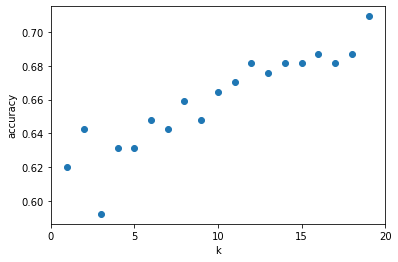

In [357]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

In [393]:
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model


In [394]:
df.head()

,passenger_id,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,0,0,0
2,2,1,3,26.0,0,0,7.9250,1,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,0,0,1
4,4,0,3,35.0,0,0,8.0500,1,1,0,1


In [395]:
X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [439]:
logit1 = LogisticRegression(random_state=123)

In [423]:
features = ['age', 'pclass', 'fare']

In [440]:
logit1.fit(X_train[features], y_train)

LogisticRegression(random_state=123)

In [441]:
y_pred = logit1.predict(X_train[features])

In [442]:
print('Baseline is', round(baseline_accuracy, 2))
print('Logistic Regression using age, pclass, and fare features')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train[features], y_train)))

Baseline is 0.62
Logistic Regression using age, pclass, and fare features
Accuracy of Logistic Regression classifier on training set: 0.63


In [444]:
features = ['age', 'pclass', 'fare', 'sex_male']
logit1.fit(X_train[features], y_train)
y_pred = logit1.predict(X_train[features])

In [445]:
print('Baseline is', round(baseline_accuracy, 2))
print('Logistic Regression using age, pclass, and fare features')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train[features], y_train)))

Baseline is 0.62
Logistic Regression using age, pclass, and fare features
Accuracy of Logistic Regression classifier on training set: 0.81


In [448]:
features = ['pclass'] #just pclass
logit1.fit(X_train[features], y_train)
y_pred = logit1.predict(X_train[features])

print('Baseline is', round(baseline_accuracy, 2))
print('Logistic Regression using just pclass feature')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train[features], y_train)))

Baseline is 0.62
Logistic Regression using just pclass feature
Accuracy of Logistic Regression classifier on training set: 0.67


In [449]:
logit2 = LogisticRegression(random_state=123, C = 5) # added C value = 5

features = ['age', 'pclass', 'fare', 'sex_male']
logit2.fit(X_train[features], y_train)
y_pred = logit2.predict(X_train[features])

print('Baseline is', round(baseline_accuracy, 2))
print('Logistic Regression using age, pclass, sex and fare features with added C value')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit2.score(X_train[features], y_train)))

Baseline is 0.62
Logistic Regression using age, pclass, sex and fare features with added C value
Accuracy of Logistic Regression classifier on training set: 0.81


In [450]:
logit3 = LogisticRegression(random_state=123)

features = ['age', 'fare',] # age and fare only
logit3.fit(X_train[features], y_train)
y_pred = logit3.predict(X_train[features])

print('Baseline is', round(baseline_accuracy, 2))
print('Logistic Regression using age and fare features')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit3.score(X_train[features], y_train)))

Baseline is 0.62
Logistic Regression using age and fare features
Accuracy of Logistic Regression classifier on training set: 0.63


In [453]:
logit2 = LogisticRegression(random_state=123, C = 5) # added C value = 5

features = ['age', 'pclass', 'fare', 'sex_male']
logit2.fit(X_train[features], y_train)
y_pred = logit2.predict(X_validate[features])
print('Baseline is', round(baseline_accuracy, 2))
print('Logistic Regression using age, pclass, sex and fare features with added C value')
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit2.score(X_train[features], y_train)))

Baseline is 0.62
Logistic Regression using age, pclass, sex and fare features with added C value
Accuracy of Logistic Regression classifier on training set: 0.81


In [454]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       132
           1       0.71      0.68      0.70        82

    accuracy                           0.77       214
   macro avg       0.76      0.75      0.76       214
weighted avg       0.77      0.77      0.77       214



In [74]:
from acquire import get_telco_data
get_telco_data()

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.60,593.3,No,One year,DSL,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.90,542.4,No,Month-to-month,DSL,Mailed check
2,2,1,2,1,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.90,267.4,Yes,Month-to-month,Fiber optic,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,2,1,2,9987-LUTYD,Female,0,No,No,13,...,Yes,No,No,No,55.15,742.9,No,One year,DSL,Mailed check
7039,7039,1,2,1,9992-RRAMN,Male,0,Yes,No,22,...,No,No,Yes,Yes,85.10,1873.7,Yes,Month-to-month,Fiber optic,Electronic check
7040,7040,2,1,1,9992-UJOEL,Male,0,No,No,2,...,No,No,No,Yes,50.30,92.75,No,Month-to-month,DSL,Mailed check
7041,7041,2,1,3,9993-LHIEB,Male,0,Yes,Yes,67,...,Yes,No,Yes,No,67.85,4627.65,No,Two year,DSL,Mailed check


In [358]:
from prepare import prep_telco_data
df = prep_telco_data()

In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   object 
 1   senior_citizen                         7032 non-null   int64  
 2   partner                                7032 non-null   object 
 3   dependents                             7032 non-null   object 
 4   tenure                                 7032 non-null   int64  
 5   phone_service                          7032 non-null   object 
 6   multiple_lines                         7032 non-null   object 
 7   online_security                        7032 non-null   object 
 8   online_backup                          7032 non-null   object 
 9   device_protection                      7032 non-null   object 
 10  tech_support                           7032 non-null   object 
 11  stre

In [360]:
df = df.drop(columns=['churn', 'gender', 'partner', 'dependents', 'phone_service', 'paperless_billing', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type', 'internet_service_type', 'payment_type'])
df.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,9,65.6,593.30,1,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
1,0,9,59.9,542.40,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,4,73.9,280.85,0,0,0,1,1,1,...,0,0,0,0,0,1,0,0,1,0
3,1,13,98.0,1237.85,0,1,0,1,1,1,...,1,0,1,0,0,1,0,0,1,0
4,1,3,83.9,267.40,1,1,0,1,1,1,...,1,0,0,0,0,1,0,0,0,1


In [362]:
df.churn_encoded.mode()

0    0
Name: churn_encoded, dtype: int64

In [363]:
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.churn_encoded)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.churn_encoded)

In [364]:
X_train = train.drop(columns=["churn_encoded"])
y_train = train.churn_encoded

X_validate = validate.drop(columns=["churn_encoded"])
y_validate = validate.churn_encoded

X_test = test.drop(columns=["churn_encoded"])
y_test = test.churn_encoded

In [144]:
train.churn_encoded.value_counts()

0    2891
1    1046
Name: churn_encoded, dtype: int64

In [365]:
baseline = y_train.mode()

In [366]:
matches_baseline_prediction = (y_train == 0)

In [367]:
baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.73


In [155]:
# Make the model
tree1 = DecisionTreeClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
tree1 = tree1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree1.predict(X_train)

In [156]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree1.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.73


In [157]:
pd.DataFrame(confusion_matrix(y_train, y_predictions))

,0,1
0,2891,0
1,1046,0


In [158]:
pd.crosstab(y_train, y_predictions)

col_0,0
churn_encoded,
0,2891
1,1046


In [159]:
print(classification_report(y_train, y_predictions))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2891
           1       0.00      0.00      0.00      1046

    accuracy                           0.73      3937
   macro avg       0.37      0.50      0.42      3937
weighted avg       0.54      0.73      0.62      3937



In [153]:
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.734315,0.0,0.734315,0.367158,0.539219
recall,1.000000,0.0,0.734315,0.500000,0.734315
f1-score,0.846807,0.0,0.734315,0.423404,0.621824
support,2891.000000,1046.0,0.734315,3937.000000,3937.000000


In [160]:
for i in range(2, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.808605     0.707231  0.794006     0.757918      0.781672
recall        0.942580     0.383365  0.794006     0.662973      0.794006
f1-score      0.870468     0.497210  0.794006     0.683839      0.771299
support    2891.000000  1046.000000  0.794006  3937.000000   3937.000000

Tree with max depth of 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.808605     0.707231  0.794006     0.757918      0.781672
recall        0.942580     0.383365  0.794006     0.662973      0.794006
f1-score      0.870468     0.497210  0.794006     0.683839      0.771299
support    2891.000000  1046.000000  0.794006  3937.000000   3937.000000

Tree with max depth of 4
                     0            1  accuracy    macro avg  weighted avg
precision     0.824399     0.688857   0.80061     0.756628      0.788388
recall        0.925631     0.455067   0.80061  

In [161]:
metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.794006,0.776066,0.017939
1,3,0.794006,0.776066,0.017939
2,4,0.800610,0.777844,0.022766
3,5,0.806960,0.776066,0.030893
4,6,0.817374,0.779028,0.038345
5,7,0.831852,0.763626,0.068226
6,8,0.842774,0.763626,0.079148
7,9,0.859792,0.760071,0.099721
8,10,0.880112,0.751777,0.128335
9,11,0.898908,0.740521,0.158386


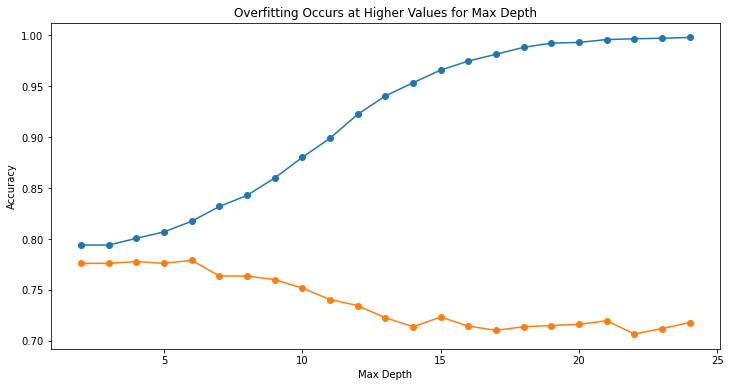

In [163]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [162]:
df[df.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

,max_depth,train_accuracy,validate_accuracy,difference
4,6,0.817374,0.779028,0.038345
2,4,0.800610,0.777844,0.022766
0,2,0.794006,0.776066,0.017939
1,3,0.794006,0.776066,0.017939
3,5,0.806960,0.776066,0.030893
5,7,0.831852,0.763626,0.068226
6,8,0.842774,0.763626,0.079148
7,9,0.859792,0.760071,0.099721


In [274]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=6,
                            n_estimators=100,
                            max_depth=15, 
                            random_state=123)

In [275]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=6, random_state=123)

In [276]:
print(rf.feature_importances_)

[0.09698363 0.11930094 0.08080159 0.03854143 0.01714747 0.15641137
 0.0189457  0.4439115  0.01135351 0.01660285]


In [277]:
y_pred = rf.predict(X_train)

In [278]:
y_pred_proba = rf.predict_proba(X_train)

In [279]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.88


In [280]:
print(confusion_matrix(y_train, y_pred))

[[297  10]
 [ 49 142]]


In [281]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       307
           1       0.93      0.74      0.83       191

    accuracy                           0.88       498
   macro avg       0.90      0.86      0.87       498
weighted avg       0.89      0.88      0.88       498



In [282]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.80


In [329]:
from sklearn.neighbors import KNeighborsClassifier

In [368]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [369]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [370]:
y_pred = knn.predict(X_train)

In [371]:
y_pred_proba = knn.predict_proba(X_train)

In [372]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.83


In [373]:
print(confusion_matrix(y_train, y_pred))

[[2663  228]
 [ 433  613]]


In [374]:
TP = 2663
TN = 613
FP = 228
FN = 433

ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.8321056642113285
True Positive Rate: 0.8601421188630491
False Positive Rate: 0.27110582639714625
True Negative Rate: 0.7288941736028538
False Negative Rate: 0.1398578811369509
Precision: 0.9211345555171221
Recall: 0.8601421188630491
F1 Score: 0.8895941205946216
Support (0): 3096
Support (1): 841


In [375]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2891
           1       0.73      0.59      0.65      1046

    accuracy                           0.83      3937
   macro avg       0.79      0.75      0.77      3937
weighted avg       0.83      0.83      0.83      3937



In [376]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.76


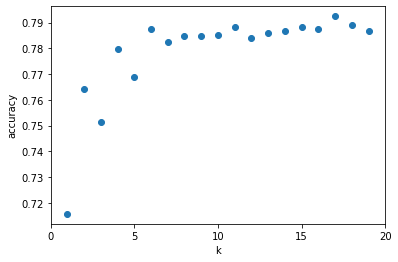

In [377]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()